# Raport - metody głębokiego uczenia - pd 1.

Autorzy: Olaf Skrabacz, Tymoteusz Makowski

## Wczytanie pakietów

In [1]:
import numpy as np
import pandas as pd
from NeuralNetwork import NeuralNetwork
from Layer import Layer
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import numpy as np

from matplotlib import animation, rc
from IPython.display import HTML
sns.set_style("darkgrid")
np.random.seed(1337)

## Regresja

### Zbiór 1  - XOR

Wczytajmy dane.

In [2]:
df = pd.read_csv("Classification//data.XOR.train.1000.csv")
df_test = pd.read_csv("Classification//data.XOR.test.1000.csv")

Wizualizacjia zbiorów.

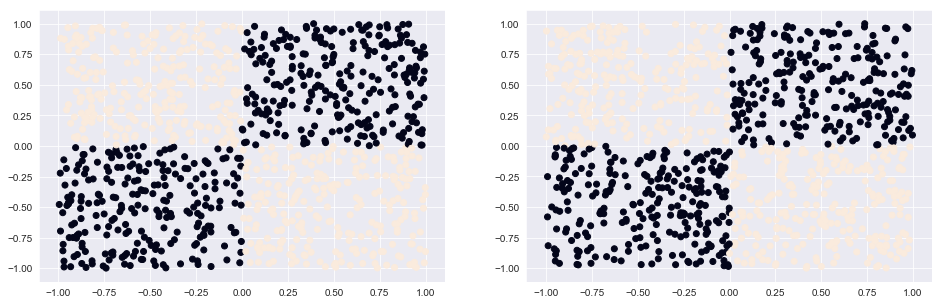

In [6]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.scatter(df['x'], df['y'], c=df['cls'])
plt.subplot(1, 2, 2)
plt.scatter(df_test['x'], df_test['y'], c=df_test['cls'])

In [70]:
X = df[['x','y']].values
y = df['cls'].values.reshape(-1,1) - 1
X_test = df_test[['x','y']].values
y_test = df_test['cls'].values.reshape(-1,1) - 1

In [71]:
nn = NeuralNetwork(loss="cross_entropy", momentum=0)
nn.add(Layer(units=50, input_shape=2, activation_function="relu"))
nn.add(Layer(units=1, input_shape=50, activation_function="sigmoid"))

In [87]:
loss, test_loss, grad_norm = nn.train(X, y, X_test, y_test,epochs=500, learning_rate=1e-2, momentum=0, verbose=True)

499

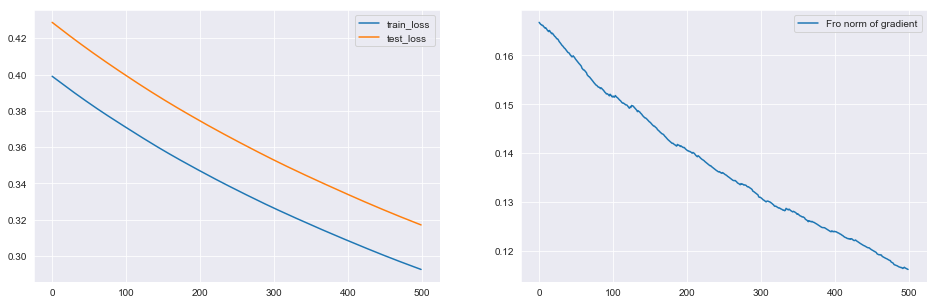

In [88]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(loss, label='train_loss')
plt.plot(test_loss, label='test_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(grad_norm, label='Fro norm of gradient')
plt.legend()

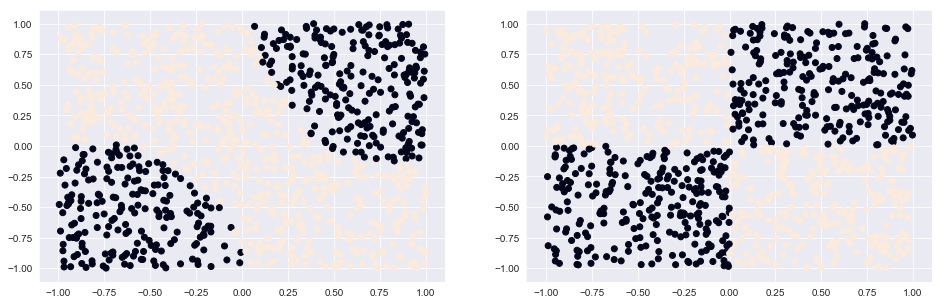

In [89]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.scatter(df['x'], df['y'], c=nn.forward_pass(X).reshape(-1) > 0.5)
plt.subplot(1, 2, 2)
plt.scatter(df_test['x'], df_test['y'], c=df_test['cls'])

Zgadzą się to z wartościami widocznymi na wykresie predykcji sieci neuronowej.

Zobaczmy teraz czy dodanie liniowych warstw poprawi jakoś wynik sieci.

In [10]:
nn = NeuralNetwork(loss="mse", momentum=0)
nn.add(Layer(units=5, input_shape=1, activation_function="linear"))
nn.add(Layer(units=5, input_shape=5, activation_function="linear"))
nn.add(Layer(units=1, input_shape=5, activation_function="linear"))

In [11]:
loss, test_loss, grad_norm = nn.train(X, y, X_test, y_test, epochs=100, learning_rate=1e-3, momentum=0, verbose=False)

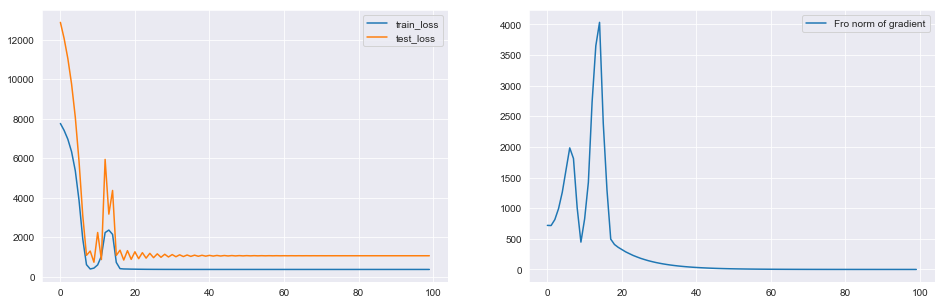

In [12]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(loss, label='train_loss')
plt.plot(test_loss, label='test_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(grad_norm, label='Fro norm of gradient')
plt.legend()

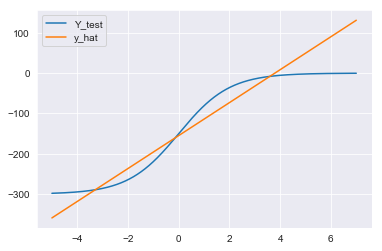

In [13]:
plt.plot(df_test['x'], df_test['y'], label='Y_test')
plt.plot(df_test['x'], nn.forward_pass(X_test), label='y_hat')
plt.legend()

Pomimo dodania warstw liniowych predykcja sieci się nie bardzo nie zmieniła. Jest to zgodne z teorią, ponieważ sieć z dowolną liczbą warstw tylko liniowych jesteśmy w stanie przedstawic jako sieć jednej warstwie liniowej. Sieć również dużo szybciej zbiegła jednak może to wynikać z losowo dobrze trafionej aktywacji.

Skoro dodanie warstw liniowych nic nie dało dodajmy warstwy nieliniowe.  
Dostępne funkcje aktywacji to:   
    1) relu,  
    2) sigmoid,  
    3) tanh,  
    4) softmax,  

Zróbmy podobną sieć tylko zastąpmy aktywację warstw głębokich na `relu`

In [14]:
nn = NeuralNetwork(loss="mse", momentum=0)
nn.add(Layer(units=5, input_shape=1, activation_function="relu"))
nn.add(Layer(units=5, input_shape=5, activation_function="relu"))
nn.add(Layer(units=1, input_shape=5, activation_function="linear"))

In [15]:
loss, test_loss, grad_norm = nn.train(X, y, X_test, y_test, epochs=100, learning_rate=1e-3, momentum=0, verbose=False)

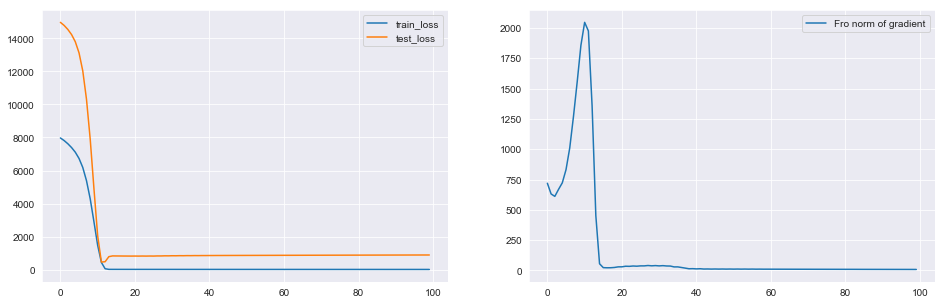

In [16]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(loss, label='train_loss')
plt.plot(test_loss, label='test_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(grad_norm, label='Fro norm of gradient')
plt.legend()

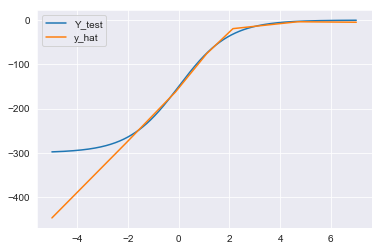

In [17]:
plt.plot(df_test['x'], df_test['y'], label='Y_test')
plt.plot(df_test['x'], nn.forward_pass(X_test), label='y_hat')
plt.legend()

Widać już nielinowość w predykcji sieci. Dodatkowo nieliniowość ma podobne złamanie to funckja `relu` w 0. Widać również że większy błąd sieci pojawia się głównie w części której nie było w zbiorze treningowym.  
Narazie uczyliśmy naszą sieć na małej liczbie obserwacji. Sprawdźmy jak wygląda predkycja zależnie od liczby obserwacji w zbiorze uczącym, oraz jak szybko sieć zbiega. Wykorzystamy architekturę sieci z poprzedniego przykładu.

In [18]:
no_obs = [100,500, 1000, 10000]

In [19]:
trains = []
tests = []
for obs in no_obs:
    trains.append(pd.read_csv(f"Regression//data.activation.train.{obs}.csv"))
    tests.append(pd.read_csv(f"Regression//data.activation.test.{obs}.csv"))

In [22]:
def define_network():
    nn = NeuralNetwork(loss="mse", momentum=0)
    nn.add(Layer(units=5, input_shape=1, activation_function="relu"))
    nn.add(Layer(units=5, input_shape=5, activation_function="relu"))
    nn.add(Layer(units=1, input_shape=5, activation_function="linear"))
    return nn

Poniższe cztery pary wykresów pokazują błąd na zbiorze traingowym, testowym oraz norme gradientu dla zbiorów o odpowiednio 100, 500, 1000 i 10000 obserwacji. Ważne jest również by każda sieć byłą inicliaziowana z tym samym ziarnem, by wagi startowe były te same.

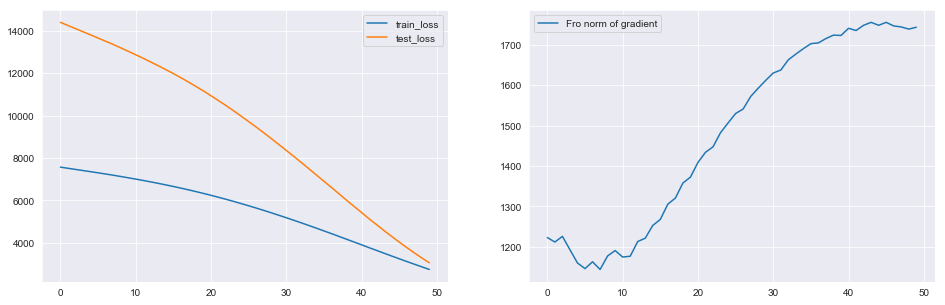

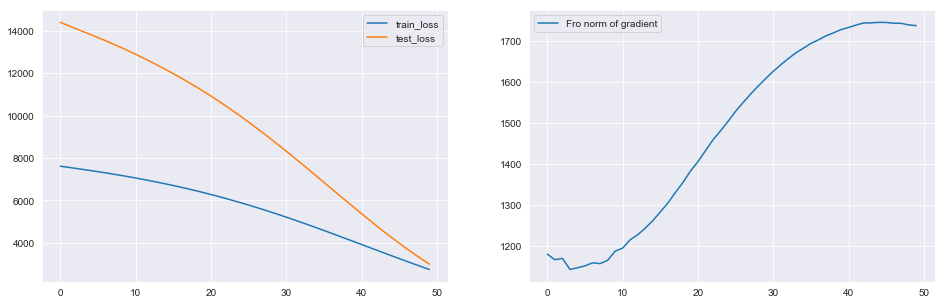

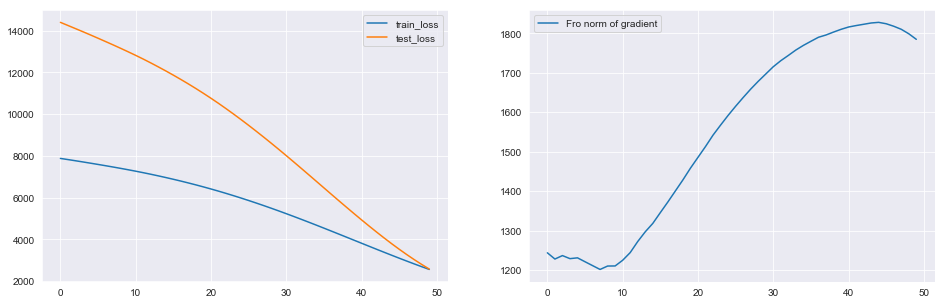

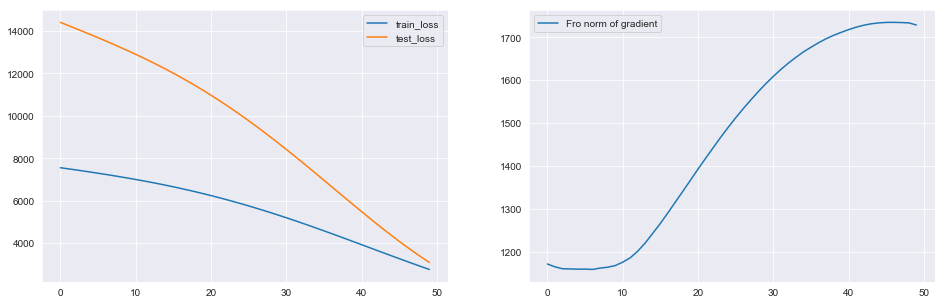

In [27]:
nn = define_network()
for train, test in zip(trains, tests):
    X = train['x'].values.reshape(-1,1); y = train['y'].values.reshape(-1,1)
    X_test = test['x'].values.reshape(-1,1); y_test = test['y'].values.reshape(-1,1)
    nn2 = deepcopy(nn)
    loss, test_loss, grad_norm = nn2.train(X, y, X_test, y_test, epochs=50, learning_rate=1e-4, momentum=0, verbose=False)
    plt.figure(figsize=(16,5))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='train_loss')
    plt.plot(test_loss, label='test_loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(grad_norm, label='Fro norm of gradient')
    plt.legend()

Na powyższych wykresach widać, że wraz z wzrostem liczby obserwacji w zbiorze testowym zwiększa szybkość uczenia, tzn. w tylu samych epokach sieć jest w stanie osiągnąć niższy błąd. Niestety taka sieć uczy się znacznie dłużej(pod względem czasu obliczeniowego).

### Zbiór 2 - Cube

Weźmiemy zbiory z 1000 obserwacjami.

In [2]:
df = pd.read_csv("Regression//data.cube.train.10000.csv")
df_test = pd.read_csv("Regression//data.cube.test.10000.csv")

In [3]:
X = df['x'].values.reshape(-1,1); y = df['y'].values.reshape(-1,1)
X_test = df_test['x'].values.reshape(-1,1); y_test = df_test['y'].values.reshape(-1,1)

Zobaczmy jak wyglądają zbiory.

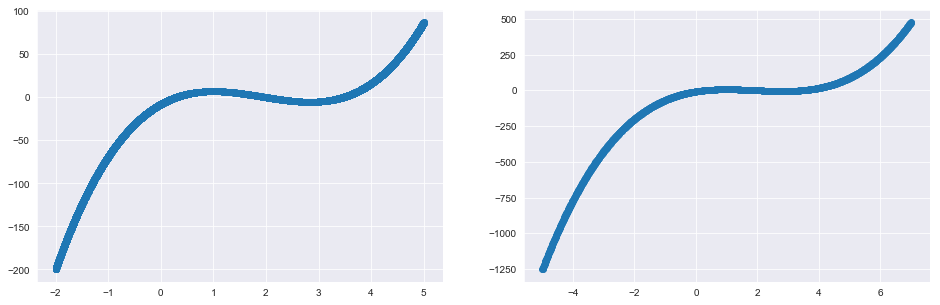

In [4]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.scatter(df['x'], df['y'])
plt.subplot(1, 2, 2)
plt.scatter(df_test['x'], df_test['y'])

Patrząc na zbiór od razu widać, że liniowe warstwy tu nie wystarczą, w tym przykładzie chciałbym porównać jak działają różne funkcję aktywacji. Skorzystamy z momentum, jednak szerzej przyjrzymy się temu zagadnieniu w następnych przykładach.

#### Sigmoid

In [24]:
nn = NeuralNetwork("mse", 0.8)
nn.add(Layer(units = 24, input_shape = 1, activation_function="sigmoid"))
nn.add(Layer(units = 24, input_shape = 24, activation_function="sigmoid"))
nn.add(Layer(units=1, input_shape=24, activation_function="linear"))

In [25]:
loss, test_loss, grad_norm = nn.train(X, y, X_test, y_test, epochs=300,
                                      learning_rate=1e-1, momentum=0.8, verbose=False)

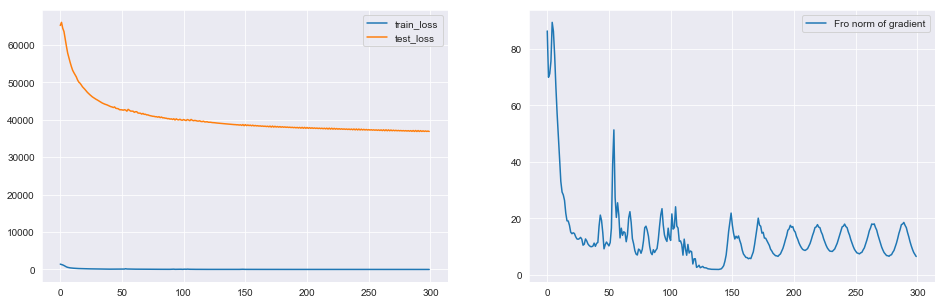

In [26]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(loss, label='train_loss')
plt.plot(test_loss, label='test_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(grad_norm, label='Fro norm of gradient')
plt.legend()

Predykcja:

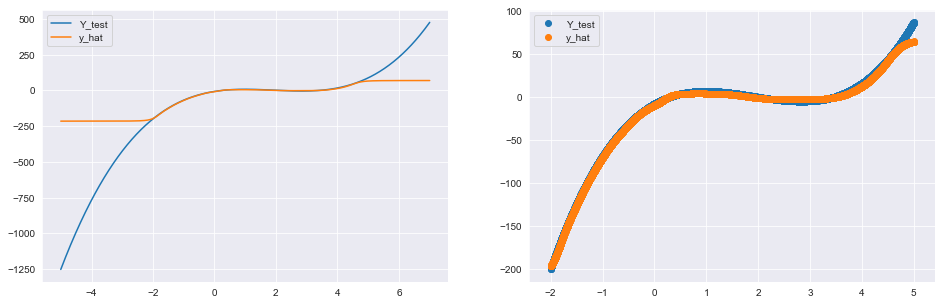

In [27]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(df_test['x'], df_test['y'], label='Y_test')
plt.plot(df_test['x'], nn.forward_pass(X_test), label='y_hat')
plt.legend()
plt.subplot(1,2,2)
plt.scatter(df['x'], df['y'], label='Y_test')
plt.scatter(df['x'], nn.forward_pass(X), label='y_hat')
plt.legend()

Sieć bardzo słabo nauczyła się zbioru poza środkową częścią pod względem wartości X. Wynika to z różnicy między zakresem X w zbiorze treningowym i testowym. Jest ona  dobrze dopasowana do zbioru treningowego.

#### Relu

In [74]:
nn = NeuralNetwork("mse", 0.6)
nn.add(Layer(units = 24, input_shape = 1, activation_function="relu"))
nn.add(Layer(units = 12, input_shape = 24, activation_function="relu"))
nn.add(Layer(units=1, input_shape=12, activation_function="linear"))

In [75]:
loss, test_loss, grad_norm = nn.train(X, y, X_test, y_test, epochs=1000,
                                      learning_rate=1e-4, momentum=0.95, verbose=False)

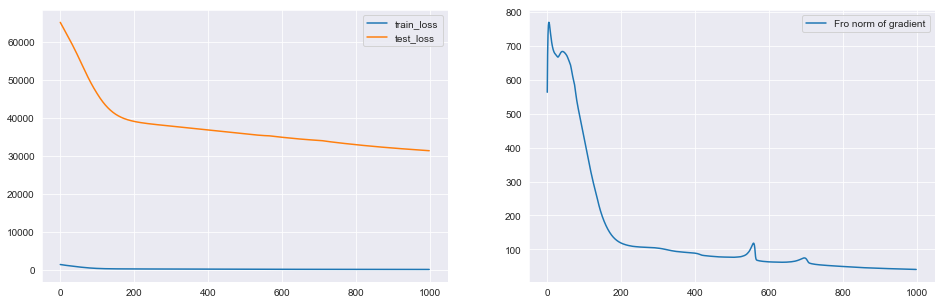

In [76]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(loss, label='train_loss')
plt.plot(test_loss, label='test_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(grad_norm, label='Fro norm of gradient')
plt.legend()

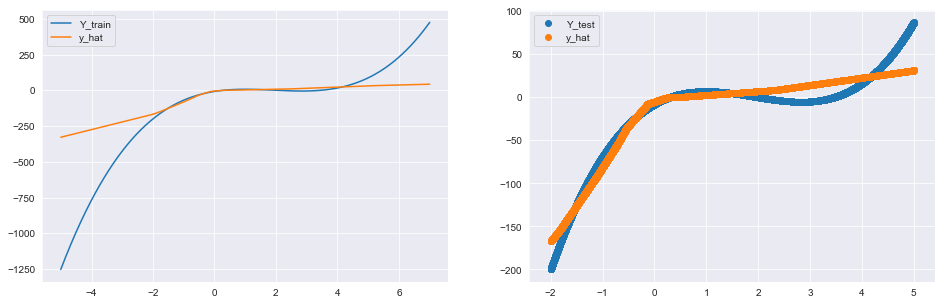

In [77]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(df_test['x'], df_test['y'], label='Y_train')
plt.plot(df_test['x'], nn.forward_pass(X_test), label='y_hat')
plt.legend()
plt.subplot(1,2,2)
plt.scatter(df['x'], df['y'], label='Y_test')
plt.scatter(df['x'], nn.forward_pass(X), label='y_hat')
plt.legend()

Sieć z warstw relu ma podobny problem co sieć z sigmoidem, jednak dużo gorzej dopasowuje się do zbioru treningowego. Może wynikać to z natury funkcji aktywacji, która nie jest tak gładka jak funkcja `sigmoid`.   
Ucząc te dwie sieci zauważamy, że sieć relu ma znacznie wyższe normy gradientów co wynika z zachowania pochodnej oraz funkcji aktywacji która dla dodatnich `x` jest liniowa. Dlatego uczać sieć relu korzystamy z znacznie niższego `learning_rate`. Gdyby zastosować takie jak w uczeniu poprzedniej sieci bardzo możliwe że natkniemy się na wybuch gradientu i problemy numeryczne.

### Zbiór 3 - Linear

In [78]:
df = pd.read_csv("Regression//data.linear.train.1000.csv")
df_test = pd.read_csv("Regression//data.linear.test.1000.csv")

In [79]:
X = df['x'].values.reshape(-1,1); y = df['y'].values.reshape(-1,1)
X_test = df_test['x'].values.reshape(-1,1); y_test = df_test['y'].values.reshape(-1,1)

Zobaczmy jak wyglądają zbiory

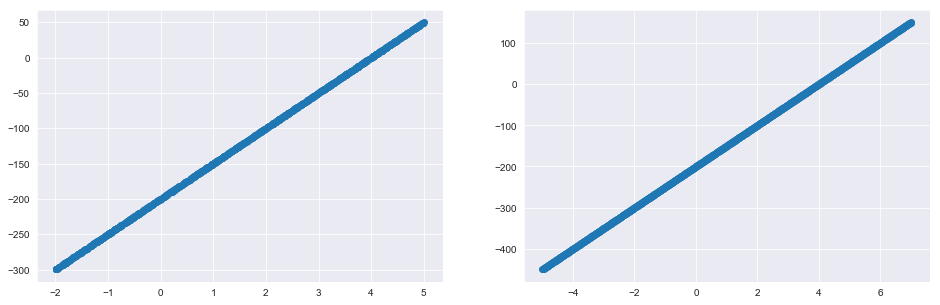

In [80]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.scatter(df['x'], df['y'])
plt.subplot(1, 2, 2)
plt.scatter(df_test['x'], df_test['y'])

Jak widać dane generowane są z funkcji liniowej `f(x) = ax + b`. Chcemy zatem stworzyć sieć, która na podstawie danych nauczy się parametrów `a` i `b`. By to zrobić stworzymy sieć jednowarstwową i zobaczymy jak wyglądaja wagi w kolejnych iteracjach uczenia.  
Dla naszych danych `b=-200` i `a=50`.

In [5]:
nn = NeuralNetwork("mse", momentum = 0)
nn.add(Layer(units=1, input_shape=1, activation_function="linear"))

Tworzymy siatkę parametrów `a` i `b` od -400 do 400, 1000 wartości

In [9]:
X_grid = np.linspace(-400, 400, 50)
Y_grid = np.linspace(-400,400,50)

In [10]:
xx,yy = np.meshgrid(X_grid,Y_grid)
flat_x, flat_y = xx.flatten().tolist(), yy.flatten().tolist()
z = np.zeros_like(flat_x)

Liczymy błąd mse w zależności od wartości parametrów W i DB

In [11]:
for i in range(len(flat_x)):
    nn.layers[1].W = np.array([[flat_x[i]]])
    nn.layers[1].B = np.array([[flat_y[i]]])
    z[i] = nn.calculate_loss(X,y).mean()

Dostajemy wykres konturowy gdzie kolor oznacza wartość funkcji straty dla sieci o danych parametrach. Ciemny niebieski oznacza minimum. Zobaczmy jak metoda spadku gradientu porusza się po tej sieci.

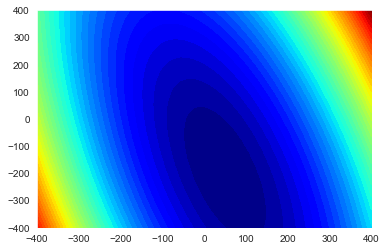

In [12]:
plt.contourf(xx,yy,z.reshape(xx.shape[0],xx.shape[1]), 50, cmap=plt.cm.jet)

In [13]:
nn = NeuralNetwork("mse", momentum = 0)
nn.add(Layer(units=1, input_shape=1, activation_function="linear"))
W = []
B = []
for i in range(10):
    W.append(nn.layers[1].W[0][0])
    B.append(nn.layers[1].B[0][0])
    nn.train(X, y, epochs=50, momentum=0, verbose=0)

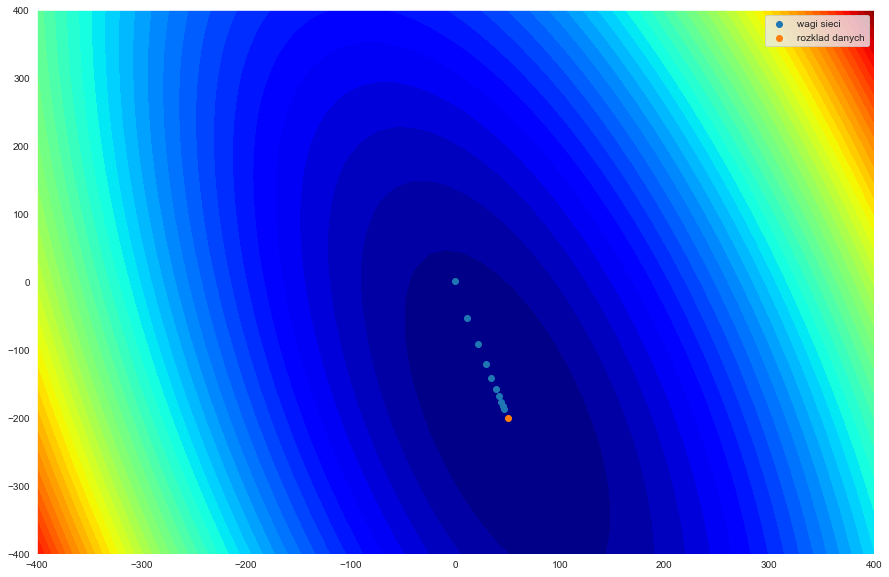

In [14]:
plt.figure(figsize=(15,10))
plt.contourf(xx,yy,z.reshape(xx.shape[0],xx.shape[1]), 50, cmap=plt.cm.jet)
plt.scatter(W, B, label='wagi sieci')
plt.scatter([50],[-200], label='rozklad danych')
plt.legend()
pass

Na wykresie widzimy jak sieć stopniowo zmienia wagi, tak by zbiegać do wag optymalnych. Proces ten jednak znacznie zwalnia wraz z zbliżaniem się do optymalnych wag.

Zobaczmy czy momentum coś zmienia w powyższym wykresie.

In [15]:
nn = NeuralNetwork("mse", momentum = 0.95)
nn.add(Layer(units=1, input_shape=1, activation_function="linear"))
W = []
B = []
for i in range(10):
    W.append(nn.layers[1].W[0][0])
    B.append(nn.layers[1].B[0][0])
    nn.train(X, y, epochs=50, momentum=0.95, verbose=0)

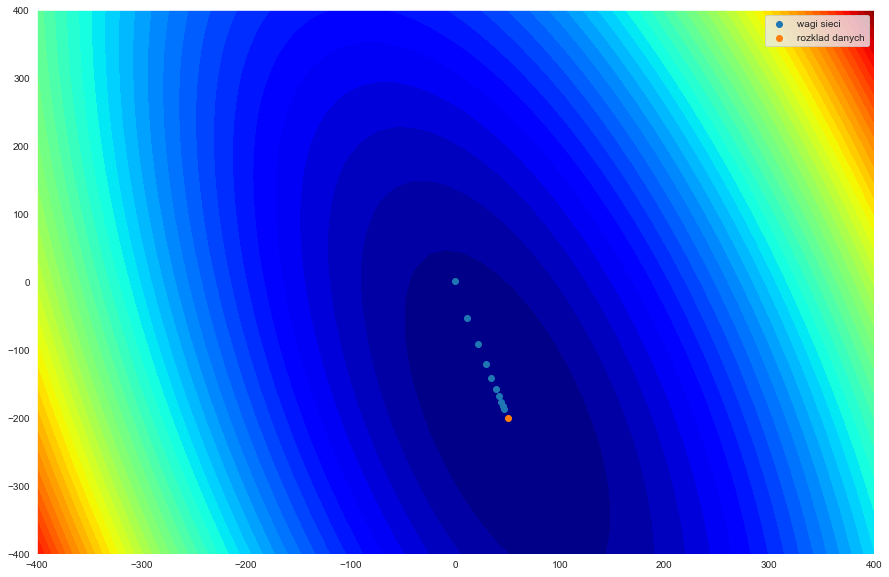

In [16]:
plt.figure(figsize=(15,10))
plt.contourf(xx,yy,z.reshape(xx.shape[0],xx.shape[1]), 50, cmap=plt.cm.jet)
plt.scatter(W, B, label='wagi sieci')
plt.scatter([50],[-200], label='rozklad danych')
plt.legend()
pass

Momentum za dużo nie zmienia ponieważ problem ten jest wypukły, tzn. mamy pewność że metoda gradientu zbiegnie do optymalnego punktu. Momentum przydaję się gdy istnieją poboczne lokalne minima, w których sieć może stanąć.

### Zbiór 4 - multimodal

In [144]:
df = pd.read_csv("Regression//data.multimodal.train.1000.csv")
df_test = pd.read_csv("Regression//data.multimodal.test.1000.csv")

In [145]:
X = df['x'].values.reshape(-1,1); y = df['y'].values.reshape(-1,1)
X_test = df_test['x'].values.reshape(-1,1); y_test = df_test['y'].values.reshape(-1,1)

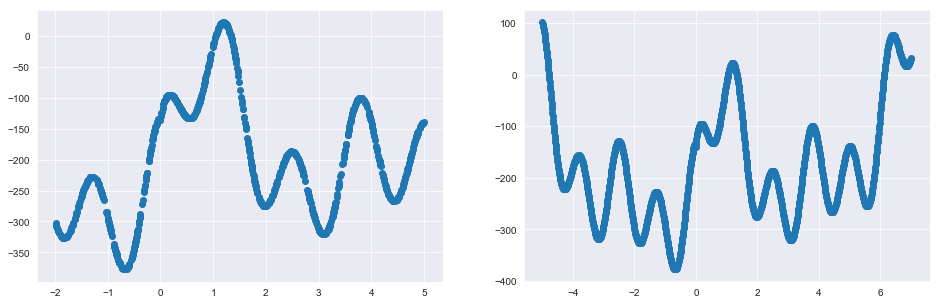

In [146]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.scatter(df['x'], df['y'])
plt.subplot(1, 2, 2)
plt.scatter(df_test['x'], df_test['y'])

Widać, że jest to najtrudniejszy problem dotychczas. Spróbujemy zbudować dużą sieć, która nauczy się powyższych zależności.

In [185]:
nn = NeuralNetwork("mse", momentum = 0.5)
nn.add(Layer(units=150, input_shape=1, activation_function="sigmoid"))
nn.add(Layer(units=1, input_shape=150, activation_function="linear"))

In [186]:
loss, test_loss, grad_norm = nn.train(X, y, X_test, y_test, epochs=1000,
                                      learning_rate=1e-2, momentum=0.5, verbose=False)

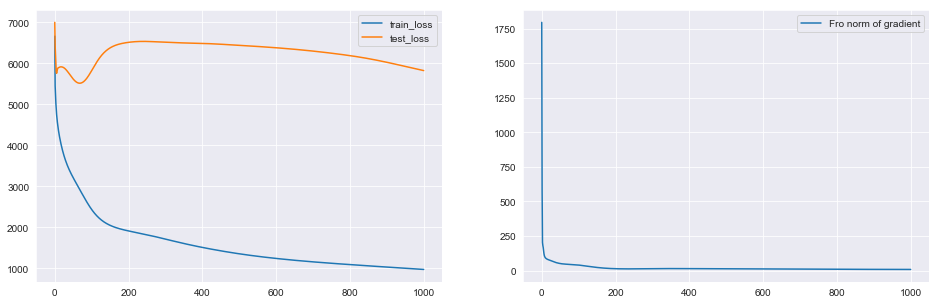

In [187]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(loss, label='train_loss')
plt.plot(test_loss, label='test_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(grad_norm, label='Fro norm of gradient')
plt.legend()

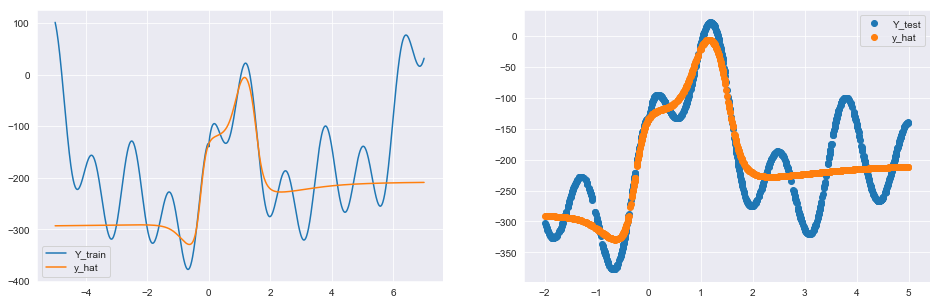

In [188]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(df_test['x'], df_test['y'], label='Y_train')
plt.plot(df_test['x'], nn.forward_pass(X_test), label='y_hat')
plt.legend()
plt.subplot(1,2,2)
plt.scatter(df['x'], df['y'], label='Y_test')
plt.scatter(df['x'], nn.forward_pass(X), label='y_hat')
plt.legend()

Widać, że jest to bardzo trudny problem dla sieci i nie uczy się ona odpowiednio. Być może zwiększenie pojemności modelu pozwoli na lepsze dopasowanie do problemu.

### Zbiór 5 - square

In [190]:
df = pd.read_csv("Regression//data.square.train.1000.csv")
df_test = pd.read_csv("Regression//data.square.test.1000.csv")

In [191]:
X = df['x'].values.reshape(-1,1); y = df['y'].values.reshape(-1,1)
X_test = df_test['x'].values.reshape(-1,1); y_test = df_test['y'].values.reshape(-1,1)

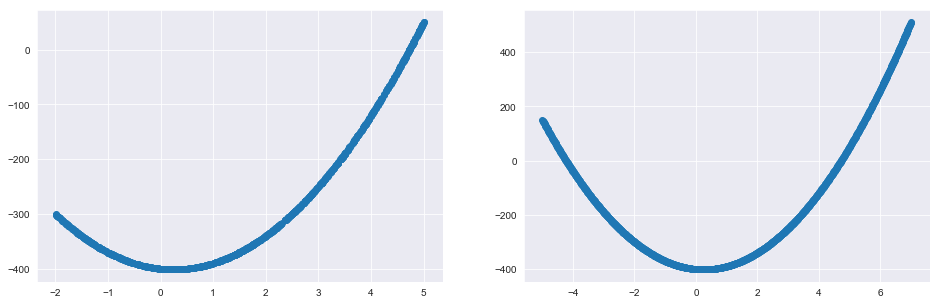

In [192]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.scatter(df['x'], df['y'])
plt.subplot(1, 2, 2)
plt.scatter(df_test['x'], df_test['y'])

Ostatni problem to funkcja kwadratowa z którą sieć o conajmniej jednej warstwie sigmoidalnej nie powinna mieć problemu.

In [207]:
nn = NeuralNetwork("mse", momentum = 0.5)
nn.add(Layer(units=50, input_shape=1, activation_function="sigmoid"))
nn.add(Layer(units=50, input_shape=50, activation_function="sigmoid"))
nn.add(Layer(units=1, input_shape=50, activation_function="linear"))

In [208]:
loss, test_loss, grad_norm = nn.train(X, y, X_test, y_test, epochs=300,
                                      learning_rate=1e-2, momentum=0.5, verbose=False)

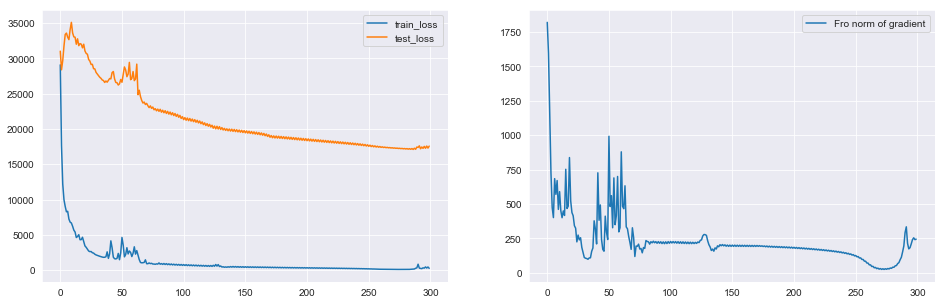

In [209]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(loss, label='train_loss')
plt.plot(test_loss, label='test_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(grad_norm, label='Fro norm of gradient')
plt.legend()

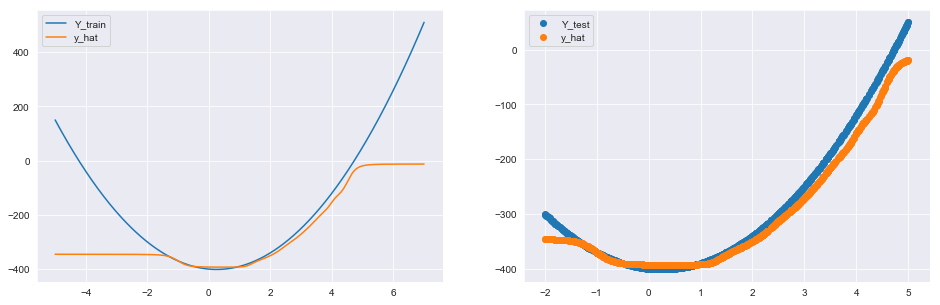

In [210]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(df_test['x'], df_test['y'], label='Y_train')
plt.plot(df_test['x'], nn.forward_pass(X_test), label='y_hat')
plt.legend()
plt.subplot(1,2,2)
plt.scatter(df['x'], df['y'], label='Y_test')
plt.scatter(df['x'], nn.forward_pass(X), label='y_hat')
plt.legend()

Sieć dopasowuje się prawie idealnie do problemu. Jednak na zbiorze testowym, gdzie zakres zmiennej `x` jest trochę szerszy niż w zbiorze treningowym widać, że sieć słabo generalizuje problem.